plotting for Paper 3

In [1]:
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import init_notebook_mode 

In [2]:
# Define common variables
outpath = '../output/'
fig_path = outpath + 'figs/'
data_path = '../data/'
import datetime
from utils.signatures import update_cumul_df, load_flow_loc

In [3]:
# import data for analysis
from common_settings import  obspath, outpath, events_name, \
    obs_events, day_load_flow, hour_load_flow, conct_name, modpath, mod_load_flow

## Plot the model performance in simulating annual loads

In [4]:
df_month = pd.read_csv(f'{outpath}mod_obs_annual.csv', index_col = 'Year')
df_month = df_month / 1000
df_month['bias'] = np.round((df_month['mod'] - df_month['obs']) / df_month['obs'], 2)

In [20]:
#setting offilne
init_notebook_mode(connected=True)
trace0 = go.Bar(
    x = df_month.index,
    y = df_month['obs'].values,
    name = 'Observation',
    marker = dict(
        color = 'rgb(49,130,189)'
    ),
)
trace1 = go.Bar(
    x = df_month.index,
    y = df_month['mod'].values,
    name = 'Simulation',
    marker=dict(
        color = 'rgb(204,204,204)'
    )
)
data = [trace0,trace1]
fig = go.Figure(data)
fig.update_layout(autosize=False,
        width=800, height=500, margin=dict(l=20, r=20, t=20, b=20),
         xaxis=dict(title_text = 'Year', 
                    titlefont=dict(size=20, family='Arial')),
         yaxis=dict(title_text = 'Annual DIN load (t)',
                    titlefont=dict(size=20, family='Arial')),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.78, 
                    font=dict(size=20)), font_family="Arial", font_color='black')
fig.update_xaxes(tickfont=dict(family='Arial', color='black', size=20))
fig.update_yaxes(tickfont=dict(family='Arial', color='black', size=20))
x_annot = np.linspace(0, 8, 9)
y_annot = [55, 105, 60, 70, 60, 30, 45, 82, 20]
for ii in range(9):
    fig.add_annotation(x = x_annot[ii], y = y_annot[ii],
                text = r'RE=%.0f%%' % (df_month['bias'].values[ii]*100),
                showarrow=False,
                arrowhead=1, 
                font = dict(size=16))

# Add the annotation for Bias
fig.add_annotation(x=9, y=55, text=r'PBIAS=%.0f%%'%(df_month['bias'].values[-1]*100), 
                   font = dict(color='tomato', size=16), arrowhead=1, showarrow=False)

pio.write_image(fig, fig_path + 'annual_load_bias_plotly.png')

## Plot hysteresis of SSL-Q

In [56]:
# Reform the dataset into two-level of columns
monthly_flow_load_mean = pd.read_csv(outpath+'monthly_flow_load_mean.csv', skiprows=[0, 2], usecols = np.arange(1, 6))
monthly_flow_load_mean.set_index('Unnamed: 5', inplace=True)
monthly_flow_load_mean.index.name = 'Month'
monthly_flow_load_mean.columns = [['mod', 'mod', 'obs','obs' ], ['Load (kg)', 'Flow (ML)', 'Load (kg)', 'Flow (ML)']]
# month_labels = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']

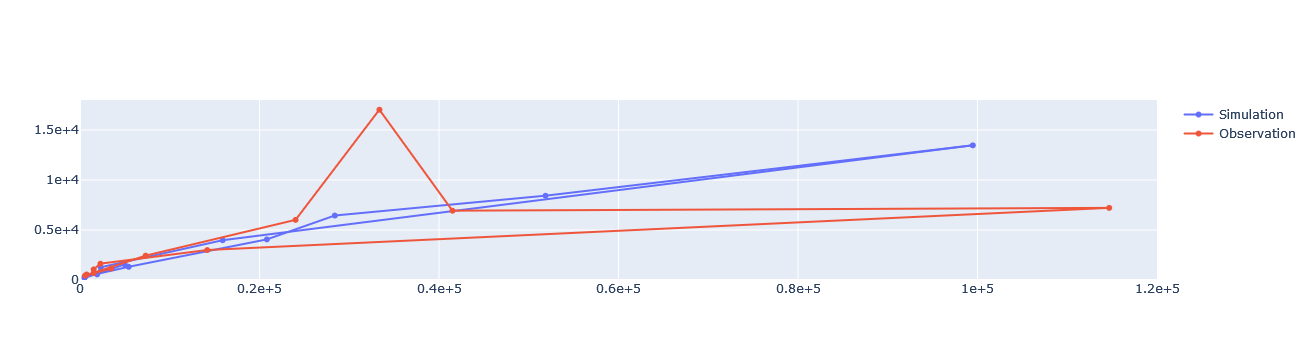

In [74]:
# Plot observed data
df_obs  = monthly_flow_load_mean['obs']
df_mod = monthly_flow_load_mean['mod']
month_labels = ['', '', '', '', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', '', '']
fig = go.Figure()
for df, legend in zip([df_mod, df_obs], ['Simulation', 'Observation']):
    fig.add_trace(go.Scatter(x = df['Flow (ML)'], y = df['Load (kg)'],  mode = 'lines+markers', name = legend, text = month_labels))
    # fig = px.line(df, x = 'Flow (ML)', y='Load (kg)', )

fig.update_traces(textposition = 'bottom left')
fig.update_xaxes(showexponent = 'all', range=[0, 1.2e5], exponentformat = 'e')

fig.update_yaxes(showexponent = 'all', range=[0, 1.8e4], exponentformat = 'e')
fig.show()
# pio.write_image(fig, '../output/figs/SSL-Q_hysteresis_obs.png', width=5, height=4, scale=2)

## The seasonal correlation between concentration and discharge

In [21]:
time_ranges = [[f'{year}/7/1', f'{year}/10/1', f'{year+1}/1/1', f'{year+1}/4/1', f'{year+1}/7/1'] for year in range(2009, 2018)]
df_ratio = pd.DataFrame(index=[str(year) for year in range(2009, 2018)], columns = [1, 2, 3, 4])
cols = mod_load_flow.columns # mod_load_flow, day_load_flow
conc_flow_df = mod_load_flow

In [22]:
# Calculate the correlation coefficient for each season
from scipy.stats import kendalltau
from scipy.stats import kendalltau, pearsonr
kr_all = {}
for ii in range(4):
    x, y = np.array([]), np.array([])
    for tt in time_ranges:
        start = pd.to_datetime(tt[ii])
        end = pd.to_datetime(tt[ii + 1]) - datetime.timedelta(days=1)   
        df = load_flow_loc([start, end], day_load_flow, timestep ='d')
        df_sum = df.sum(axis=0)
        if x.shape[0] == 0:
            y = df[cols[1]].values
            x = df[cols[2]].values
        else:
            x = np.append(x, df[cols[2]].values)
            y = np.append(y, df[cols[1]].values)
    # Calculate the pearson correlation
    kr_temp = kendalltau(x, y)
    kr_all[ii] = kr_temp
    print("pearson 相关系数： ", kr_temp)

pearson 相关系数：  KendalltauResult(correlation=0.09705652246737749, pvalue=2.920073894799085e-05)
pearson 相关系数：  KendalltauResult(correlation=0.28012248080089364, pvalue=1.6754373763576252e-33)
pearson 相关系数：  KendalltauResult(correlation=-0.40385348384805203, pvalue=1.7342991921328826e-66)
pearson 相关系数：  KendalltauResult(correlation=-0.16629522773354416, pvalue=1.0551734769904672e-12)


In [23]:
# Form the data into four seasons
data_x, data_y = {'mod':{}, 'obs':{}}, {'mod':{}, 'obs':{}}
x_col, y_col = cols[2], cols[0]
for ii in range(4):
    x, y = np.array([]), np.array([])
    x_obs, y_obs = np.array([]), np.array([])
    for tt in time_ranges:
        start = pd.to_datetime(tt[ii])
        end = pd.to_datetime(tt[ii + 1]) - datetime.timedelta(days=1)   
        df = load_flow_loc([start, end], mod_load_flow, timestep ='d')
        df_obs = load_flow_loc([start, end], day_load_flow, timestep ='d')

        if x.shape[0] == 0:
            x = df[x_col].values
            y = df[y_col].values
            x_obs = df_obs[x_col].values
            y_obs = df_obs[y_col].values
        else:
            x = np.append(x, df[x_col].values)
            y = np.append(y, df[y_col].values)
            x_obs = np.append(x_obs, df_obs[x_col].values)
            y_obs = np.append(y_obs, df_obs[y_col].values)

    data_x['mod'][f'x_{ii}'] = x
    data_y['mod'][f'y_{ii}'] = y
    data_x['obs'][f'x_{ii}'] = x_obs
    data_y['obs'][f'y_{ii}'] = y_obs

In [24]:
# Read regression coefficients and standard errors
coeffs_obs = pd.read_csv(outpath + 'obs_cl_regress_error.csv', index_col = 'Unnamed: 0')
coeffs_mod = pd.read_csv(outpath + 'mod_cl_regress_error.csv', index_col = 'Unnamed: 0')

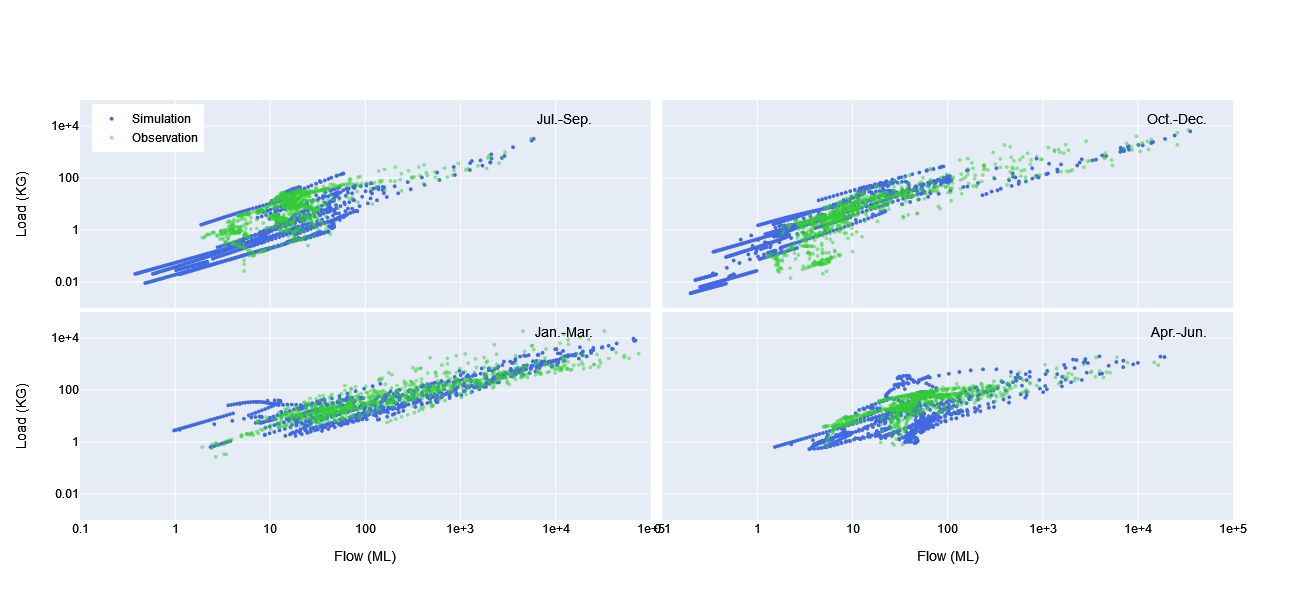

In [101]:
# Use plotly to creat scatter plots
# Initialize figure with subplots
fig = make_subplots(rows=2, cols=2, shared_yaxes=True, shared_xaxes=True, 
                    horizontal_spacing = 0.01, vertical_spacing = 0.01)
legends = ['Jul.-Sep.', 'Oct.-Dec.', 'Jan.-Mar.', 'Apr.-Jun.']

# Plot here
fig.add_trace(
        go.Scatter(x=data_x['mod'][f'x_{0}'], y=data_y['mod'][f'y_{0}'], mode='markers', 
                   name='Simulation', marker=dict(color='royalblue', size=4)),
        row = 1, col = 1)

fig.add_trace(
        go.Scatter(x=data_x['obs'][f'x_{0}'], y=data_y['obs'][f'y_{0}'], mode='markers', name='Observation',
                  marker=dict(color='limegreen', size=4, opacity=0.5)),
        row = 1, col = 1)


for ii in range(1, 4):
    fig.add_trace(
        go.Scatter(x=data_x['mod'][f'x_{ii}'], y=data_y['mod'][f'y_{ii}'], mode='markers', 
                   showlegend=False, marker=dict(color='royalblue', size=4)),
        row = (ii//2 + 1), col= (ii % 2 + 1))

for ii in range(1, 4):
    fig.add_trace(
        go.Scatter(x=data_x['obs'][f'x_{ii}'], y=data_y['obs'][f'y_{ii}'], mode='markers', showlegend=False,
                  marker=dict(color='limegreen', size=4, opacity=0.5)),
         row = (ii//2 + 1), col= (ii % 2 + 1))

    
fig.update_layout(height=600, width=800)
fig.update_xaxes(type="log", range=[-1, 5])
fig.update_yaxes(type="log", range=[-3, 5])
for jj in range(1, 3):
    fig.update_xaxes(showexponent = 'all', exponentformat = 'e', 
                     row = 2, col = jj, title_text = 'Flow (ML)') 
    fig.update_yaxes(showexponent = 'all', exponentformat = 'e', 
                     row = jj, col = 1, title_text = 'Load (KG)') 

fig.update_layout(legend = dict(yanchor="top", y = 0.99, xanchor = "left", x = 0.01, 
                font = dict(size=12)), font_family = "Arial", font_color = 'black')

x_loc = [0.2, 0.98] * 2; y_loc = [0.6, 0.6, 0.08, 0.08]
subtitle_xloc = [0.42, 0.98] * 2; subtitle_yloc = [0.98, 0.98, 0.45, 0.45]
for ii in range(4):
    regress_col = str(ii+1)
    fig.add_annotation(dict(x=x_loc[ii], y= y_loc[ii], xref="paper", yref="paper", 
                                    text=r'$DIN_o = %.2f(%.2f)*Q_o^{%.2f(%.2f)}$' %(coeffs_obs.loc['a', regress_col], 
                                        coeffs_obs.loc['a_error', regress_col], coeffs_obs.loc['b', regress_col], 
                                                coeffs_obs.loc['b_error', regress_col]), showarrow=False))
    # Add the seassons to each subplot
    fig.add_annotation(dict(x = subtitle_xloc[ii], y = subtitle_yloc[ii], xref = "paper", yref = "paper", 
                                    text = legends[ii], font = dict(size=14)), showarrow = False)
    
for ii in range(4):
    regress_col = str(ii+1)
    if coeffs_mod.loc['c',regress_col] == 0:
        fig.add_annotation(dict(x=x_loc[ii], y= y_loc[ii] - 0.06, xref="paper", yref="paper", 
                                    text=r'$DIN_m = %.2f(%.2f)*Q_m^{%.2f(%.2f)}$' %(coeffs_mod.loc['a', regress_col], 
                                        coeffs_mod.loc['a_error', regress_col], coeffs_mod.loc['b', regress_col], 
                                            coeffs_mod.loc['b_error', regress_col]), showarrow=False))
    else:
        # Change the location of subplot at row = 2, col = 1
        if ii == 2:
            xx = x_loc[ii] - 0.1
        else:
            xx = x_loc[ii]
            
        fig.add_annotation(dict(x=xx , y=y_loc[ii] - 0.06, xref="paper", yref="paper", 
                                    text=r'$DIN_m = %.2f(%.2f)*Q_m^{%.2f(%.2f)}+%.2f(%.2f)$' %(coeffs_mod.loc['a', regress_col], 
                                        coeffs_mod.loc['a_error', regress_col], coeffs_mod.loc['b', regress_col], coeffs_mod.loc['b_error', regress_col],
                                                    coeffs_mod.loc['c', regress_col], coeffs_mod.loc['c_error', regress_col]), showarrow=False))
# Add the annotation of fitting statistic R2    
    fig.add_annotation(dict(x = x_loc[ii], y = y_loc[ii] + 0.05), xref="paper", yref="paper", 
                        text = r'$R^2_o = %.2f, R^2_m = %.2f$'%(coeffs_obs.loc['R2', regress_col],
                                                               coeffs_mod.loc['R2', regress_col]), showarrow=False)
    
fig.show()
pio.write_image(fig, fig_path + 'DIN-Q_scatter_plot.png', scale=2)

## Calculate the cumulative SSL-Q

In [10]:
# Read cumulative of normalized data
fn_day = 'obs_year_cumulative_ratio_day'
df_day = pd.read_excel(f'{outpath}{fn_day}.xlsx', sheet_name=[f'obs_year_{i}' for i in range(9)]);
fn_mod = 'mod_year_cumulative_ratio_day'
df_mod = pd.read_excel(f'{outpath}{fn_mod}.xlsx', None);

In [11]:
# reshape the dataframe for plotting
# Formatting model simulations
df_mod_plot = pd.DataFrame(columns = ['Date', 'cumul_flow_ratio', 'cumul_load_ratio'])
for k, v in df_mod.items():
    df_mod_plot = pd.concat([df_mod_plot, v.loc[:, ['Date', *v.columns[-2:]]]])
df_mod_plot.set_index('Date', inplace=True)
df_mod_plot.index= pd.to_datetime(df_mod_plot.index)

# Formatting observations
df_obs_plot = pd.DataFrame(columns = ['Date', 'cumul_flow_ratio', 'cumul_load_ratio'])
for k, v in df_day.items():
    df_obs_plot = pd.concat([df_obs_plot, v.loc[:, ['Date', *v.columns[-2:]]]])
df_obs_plot.set_index('Date', inplace=True)
df_obs_plot.index= pd.to_datetime(df_obs_plot.index)

In [12]:
# read inputs (*cumulative_ratio*.xlsx)
xlabel='Normalized cumulative discharge'
ylabel='Normalized cumulative mass'

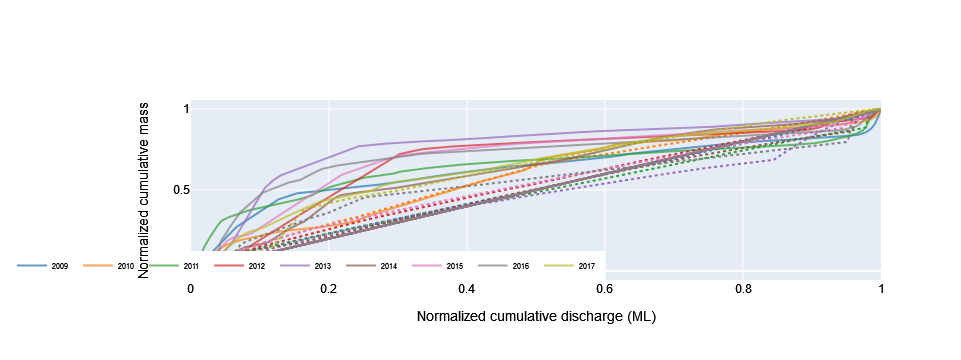

In [20]:
# fig = go.Figure()
# color_list = px.colors.qualitative.D3
# for ii in range(2009, 2018):
#     # Plot simulations
#     df_mod_temp = df_mod_plot.loc[pd.to_datetime(f'{ii}-07-01'):pd.to_datetime(f'{ii+1}-07-01'), :].values
#     fig.add_trace(go.Scatter(x = df_mod_temp[:, 0], y=df_mod_temp[:, 1], mode = 'lines', showlegend=False,
#                             line = dict(width=2, dash='dot', color = color_list[ii-2009])))
    
#     # Plot observations
#     df_obs_temp = df_obs_plot.loc[pd.to_datetime(f'{ii}-07-01'):pd.to_datetime(f'{ii+1}-07-01'), :].values
#     fig.add_trace(go.Scatter(x = df_obs_temp[:, 0], y=df_obs_temp[:, 1], mode = 'lines', name=ii,
#                             line = dict(width=2, color = color_list[ii-2009]), opacity=0.7))

# fig.update_layout(
#     yaxis = dict(
#         title_text = ylabel
#     ),
#      xaxis = dict(
#         title_text = xlabel
#     )
# )

# fig.update_layout(legend = dict(yanchor="bottom", y = 0.0, xanchor = "right", x = 0.6, 
#                 font = dict(size=8), orientation='h'), font_family = "Arial", font_color = 'black')

# fig.show()
# pio.write_image(fig, fig_path + 'SSL-Q_cumulative_lines.png', scale=2, width=8, height=6)

### Table and subplots

In [13]:
mffr = pd.read_csv(outpath + 'mffr_30.csv', index_col = 'Unnamed: 0').round(2)
mffr.reset_index(inplace=True)
mffr.rename(columns = {mffr.columns[0]:'Year',
                       mffr.columns[1]:'MFFRo',
                       mffr.columns[2]:'MFFRm'},
                        inplace=True)
color_list = px.colors.qualitative.D3

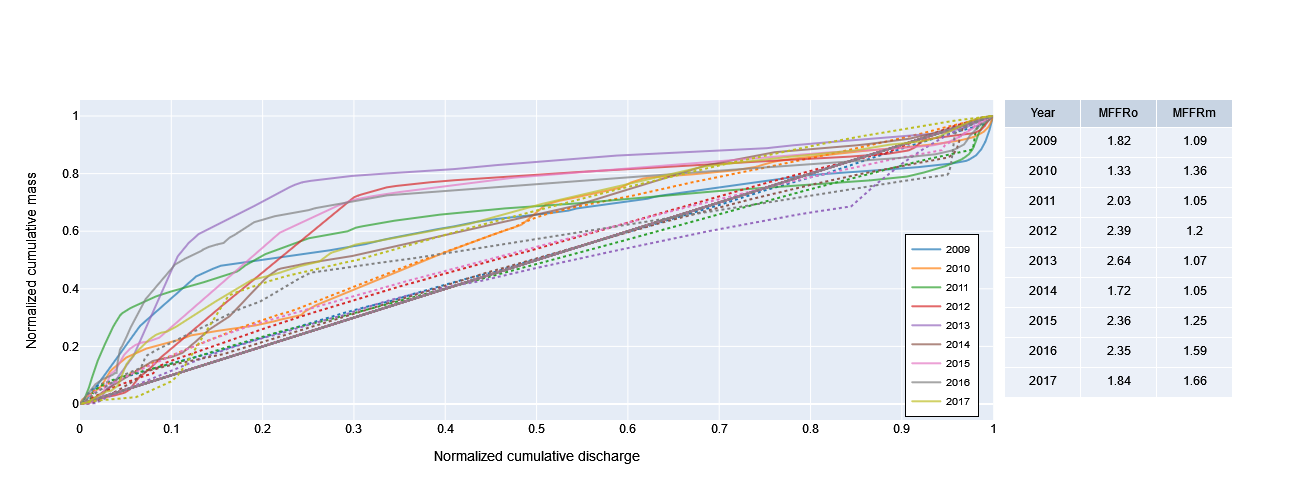

In [15]:
from plotly.subplots import make_subplots
import re

fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.8, 0.2],
    horizontal_spacing = 0.01,
    specs=[[{"type": "scatter"}, {"type": "table"}]]
)
    
for ii in range(2009, 2018):
    # Plot simulations
    df_mod_temp = df_mod_plot.loc[pd.to_datetime(f'{ii}-07-01'):pd.to_datetime(f'{ii+1}-07-01'), :].values
    fig.add_trace(go.Scatter(x = df_mod_temp[:, 0], y=df_mod_temp[:, 1], mode = 'lines', showlegend=False,
                            line = dict(width=2, dash='dot', color = color_list[ii-2009])), 
                  row=1, col=1)
    
    # Plot observations
    df_obs_temp = df_obs_plot.loc[pd.to_datetime(f'{ii}-07-01'):pd.to_datetime(f'{ii+1}-07-01'), :].values
    fig.add_trace(go.Scatter(x = df_obs_temp[:, 0], y=df_obs_temp[:, 1], mode = 'lines', name=ii,
                            line = dict(width=2, color = color_list[ii-2009]), opacity=0.7),
                  row=1, col=1)

fig.add_trace(go.Table(
        header=dict(
            values=['Year', 'MFFRo', 'MFFRm'],
            font=dict(size=12),
            align="center"
        ),
        cells=dict(
            values=[mffr[k].tolist() for k in mffr.columns[0:]],
            align = "center")
    ),
        row=1, col=2,       
)

fig.update_traces(cells_height=30, row=1, col=2)

fig.update_layout(
    yaxis = dict(
        title_text = ylabel
    ),
     xaxis = dict(
        title_text = xlabel
    )
)

fig.update_layout(height=500, width=800,
                legend = dict(yanchor="bottom", y = 0.01, xanchor = "right", x = 0.78, 
                font = dict(size=10), orientation='v', bgcolor="white",
                bordercolor="Black",
                borderwidth=1), font_family = "Arial", font_color = 'black')

fig.show()
fig.write_image(fig_path + 'SSL-Q_cumulative_lines_table_30.png', scale=2)

### Plot Event load coefficients (ELC)

In [22]:
# import EMC and tranform into a matrix
emc = pd.read_csv(f'{outpath}obs_storm_event_common3.csv', index_col='ID')
emc_mod = pd.read_csv(f'{outpath}DIN_mod_storm_event_common3.csv', index_col='ID')

In [23]:
emc_matrix = {year: [] for year in range(2009, 2018)}
emc_mod_matrix = {year: [] for year in range(2009, 2018)}
# emc_matrix = {year: [] for year in range(2009, 2014)}
emc.start = pd.to_datetime(emc.start)
emc_mod.start = pd.to_datetime(emc_mod.start)
emc.end = pd.to_datetime(emc.end)
emc_mod.end = pd.to_datetime(emc_mod.end)

In [24]:
# Calculate the discharge contribution
annual_q_obs, annual_q_mod = {}, {}
for year in range(2009, 2018):
    annual_q_obs[year] = day_load_flow.loc[f'{year}-07-01':f'{year+1}-06-30', 'Flow (ML)'].sum()
    annual_q_mod[year] = mod_load_flow.loc[f'{year}-07-01':f'{year+1}-06-30', 'Flow (ML)'].sum()

for i in range(1, emc.shape[0]+1):
    emc.loc[i, 'Q'] = day_load_flow.loc[emc.start[i]:emc.end[i], 'Flow (ML)'].sum()
    emc_mod.loc[i, 'Q'] = mod_load_flow.loc[emc_mod.start[i]:emc_mod.end[i], 'Flow (ML)'].sum()
    curr_year = emc.start[i].year
    if emc.start[i].month < 7:
        emc.loc[i, 'Q_coeff'] = emc.loc[i, 'Q']  / annual_q_obs[curr_year - 1]
        emc_mod.loc[i, 'Q_coeff'] = emc_mod.loc[i, 'Q']  / annual_q_mod[curr_year - 1]
    else:
        emc.loc[i, 'Q_coeff'] = emc.loc[i, 'Q']  / annual_q_obs[curr_year]
        emc_mod.loc[i, 'Q_coeff'] = emc_mod.loc[i, 'Q']  / annual_q_mod[curr_year]

In [25]:
col_plt = ['event_load_coefficients', 'emc(mg/l)'][0]
fig_names = ['event_load_coefficients', 'emc'][0]
# col_plt = ['Q_coeff', 'discharge'][0]
# fig_names = ['Q_coeff', 'discharge'][0]
for ii in emc.index:
    if emc.start[ii].month < 7:
        emc_matrix[emc.start[ii].year - 1].append(emc.loc[ii, col_plt]) # event_load_coefficients
    else:
        emc_matrix[emc.start[ii].year].append(emc.loc[ii, col_plt])
# convert dict into a dataframe
df_fillna = pd.DataFrame(index=np.arange(1, 12), columns=emc_matrix.keys())
mod_df_fillna = pd.DataFrame(index=np.arange(1, 12), columns=emc_matrix.keys())
for key, val in emc_matrix.items():
    df_fillna.loc[0:len(val), key] = val
    
df_fillna.fillna(0, inplace=True)
# creat a mask
mask = np.zeros_like(df_fillna.values)
mask[df_fillna == 0] = True

# For mod    
for ii in emc_mod.index:
    if emc_mod.start[ii].month < 7:
        emc_mod_matrix[emc_mod.start[ii].year - 1].append(emc_mod.loc[ii, col_plt])
    else:
        emc_mod_matrix[emc_mod.start[ii].year].append(emc_mod.loc[ii, col_plt])
        
for key, val in emc_mod_matrix.items():
    mod_df_fillna.loc[0:len(val), key] = val

mod_df_fillna.fillna(0, inplace=True)
# creat a mask
mod_mask = np.zeros_like(mod_df_fillna.values)
mod_mask[mod_df_fillna == 0] = True

In [26]:
# Calculate difference between ELCs for obs and mod
df_diff_fillna  = df_fillna - mod_df_fillna
diff_mask = np.zeros_like(df_diff_fillna.values)
diff_mask[mod_df_fillna == 0] = True

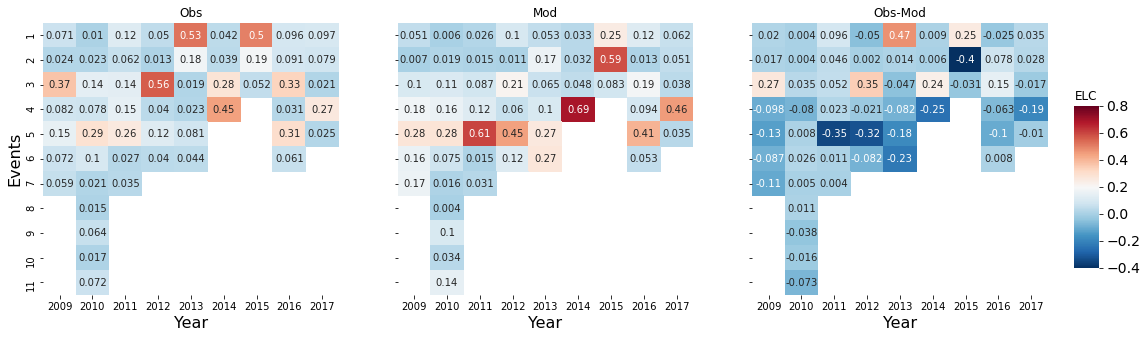

In [29]:
# sns.set_context({"figure.figsize":(17,5)})
import seaborn as sns
import matplotlib.pyplot as plt
sns.axes_style("white")
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 5))
cbar_ax = fig.add_axes([.92, .2, .02, .45], title='ELC')
ax = sns.heatmap(data=np.array(np.round(df_fillna.values, 3)), annot=True, mask=mask, vmin=-0.4, vmax=0.8,
            xticklabels=df_fillna.columns, yticklabels= df_fillna.index,cmap="RdBu_r", ax=axes[0], cbar=0)
ax1 = sns.heatmap(data=np.array(np.round(mod_df_fillna.values, 3)), annot=True, mask=mod_mask, vmin=-0.4, vmax=0.8,
            xticklabels=mod_df_fillna.columns, yticklabels= mod_df_fillna.index,cmap="RdBu_r", ax=axes[1], cbar_ax=cbar_ax)
ax2 = sns.heatmap(data=np.array(np.round(df_diff_fillna.values, 3)), annot=True, mask=diff_mask, vmin=-0.4, vmax=0.8,
            xticklabels=df_diff_fillna.columns, yticklabels= df_diff_fillna.index, cmap="RdBu_r", ax=axes[2], cbar_ax=cbar_ax)

ax.set_title('Obs')
ax1.set_title('Mod')
ax2.set_title('Obs-Mod')
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Events', fontsize=16)
ax1.set_xlabel('Year', fontsize=16)
ax2.set_xlabel('Year', fontsize=16)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14);
plt.savefig(f'{outpath}figs/obs_mod_{fig_names}_common3.png', format='png', dpi=400)

## Visualize the DIN process of selected events. 

In [4]:
# import EMC and tranform into a matrix
emc_obs = pd.read_csv(f'{outpath}obs_storm_event_common3.csv', index_col='ID')
emc_mod = pd.read_csv(f'{outpath}DIN_mod_storm_event_common3.csv', index_col='ID')
# Read observed concentration data.
fn_conc = 'gbr_WhiSun.xlsx'
conc_obs = pd.read_excel(f'{data_path}obs/{fn_conc}', sheet_name='126001A', index_col='DateTime')
conc_obs['Oxidised nitrogen (mg/L)'].replace('<0.001', 0.0005)
conc_obs['Ammonium nitrogen (mg/L)'].replace('<0.002', 0.001)
conc_obs['DIN (mg/L)'] = conc_obs['Oxidised nitrogen (mg/L)'].replace('<0.001', 0.0005) + conc_obs['Ammonium nitrogen (mg/L)'].replace('<0.002', 0.001)
conc_obs.index = pd.to_datetime(conc_obs.index)
# Read modeled concentration data.
conc_mod = pd.read_csv(f'{data_path}mod/DIN_flow.csv', index_col='Date')
conc_mod.index = pd.to_datetime(conc_mod.index)

conc_obsest = pd.read_csv(f'{data_path}obs/low_interp_flow.csv', index_col='Date')
conc_obsest.index = pd.to_datetime(conc_obsest.index, yearfirst=True)

# Read hourly flow
hour_flow = pd.read_csv(f'{data_path}obs/126001A_hourly.csv', index_col='Time')

# Convert start and end time of events into datetime.
emc_obs['start'] = pd.to_datetime(emc_obs['start'])
emc_obs['end'] = pd.to_datetime(emc_obs['end'])
emc_mod['start'] = pd.to_datetime(emc_mod['start'])
emc_mod['end'] = pd.to_datetime(emc_mod['end'])

day_load_flow['Flow (ML)'] = day_load_flow['Flow (ML)'] / 86.4
mod_load_flow['Flow (ML)'] = mod_load_flow['Flow (ML)'] / 86.4

In [5]:
# read information of the selected events
Event_ID = [1, 2, 3] # 45,
event_dict = {}
conc_dict = {}
for i in Event_ID:
    event_dict[f'event_obs_{i}'] = day_load_flow[emc_obs.loc[i, 'start']:emc_obs.loc[i, 'end']].filter(items=['Loads (kg)', 'Flow (ML)'])
    event_dict[f'event_mod_{i}'] = mod_load_flow[emc_obs.loc[i, 'start']:emc_obs.loc[i, 'end']].filter(items=['Loads (kg)', 'Flow (ML)'])
    conc_dict[f'event_obs_{i}'] = conc_obs[emc_obs.loc[i, 'start']:(emc_obs.loc[i, 'end'] + datetime.timedelta(days=1))].filter(items=['DIN (mg/L)'])
    conc_dict[f'event_mod_{i}'] = conc_mod[emc_obs.loc[i, 'start']:(emc_obs.loc[i, 'end'] + datetime.timedelta(days=1))].filter(items=['Concentration (mg/L)'])
    conc_dict[f'event_obsest_{i}'] = conc_obsest[emc_obs.loc[i, 'start']:(emc_obs.loc[i, 'end'] + datetime.timedelta(days=1))].filter(items=['Concentration (mg/L)'])


In [8]:
# read information of the selected events
# Determine whehter to change the yaxis of conc to a log type.
logy = True
for e_id in range(1, 55, 3):
        Event_ID = [e_id, e_id+1, e_id+2] # 45,
        event_dict = {}
        conc_dict = {}
        for i in Event_ID:
                event_dict[f'event_obs_{i}'] = day_load_flow[emc_obs.loc[i, 'start']:emc_obs.loc[i, 'end']].filter(items=['Loads (kg)', 'Flow (ML)'])
                event_dict[f'event_mod_{i}'] = mod_load_flow[emc_mod.loc[i, 'start']:emc_mod.loc[i, 'end']].filter(items=['Loads (kg)', 'Flow (ML)'])
                conc_dict[f'event_obs_{i}'] = conc_obs[emc_obs.loc[i, 'start']:(emc_obs.loc[i, 'end'] + datetime.timedelta(days=1))].filter(items=['DIN (mg/L)'])
                conc_dict[f'event_mod_{i}'] = conc_mod[emc_mod.loc[i, 'start']:(emc_mod.loc[i, 'end'] + datetime.timedelta(days=1))].filter(items=['Concentration (mg/L)'])
                conc_dict[f'event_obsest_{i}'] = conc_obsest[emc_obs.loc[i, 'start']:(emc_obs.loc[i, 'end'] + datetime.timedelta(days=1))].filter(items=['Concentration (mg/L)'])

        labs = ['Loads (kg)', 'Flow (ML)']
        fig = make_subplots(rows=3, cols=3, shared_yaxes=False, shared_xaxes=True, 
                                horizontal_spacing = 0.05, vertical_spacing = 0.01,
                                column_titles=[f'Event {i}'for i in Event_ID], row_heights=[1, 1, 1], column_widths=[1, 1, 1])
        show_legend = [True, False, False]
        for i in range(len(Event_ID)):
                x_obs = event_dict[f'event_obs_{Event_ID[i]}'].index
                x_mod = event_dict[f'event_mod_{Event_ID[i]}'].index
                fig.add_trace(go.Line(x = x_obs, y=event_dict[f'event_obs_{Event_ID[i]}'].loc[:, labs[1]], \
                                name=f'Obs {labs[1]}', line={'color': 'blue'}, showlegend = show_legend[i], mode='lines+markers', opacity=0.7), row=1, col= i+1)

                fig.add_trace(go.Line(x = x_mod, y=event_dict[f'event_mod_{Event_ID[i]}'].loc[:, labs[1]], \
                                name=f'Mod {labs[1]}', line={'dash' : 'dot', 'color': 'orange'}, showlegend = show_legend[i], mode='lines+markers', opacity=0.7), row=1, col= i+1)

                fig.add_trace(go.Line(x = x_obs, y=event_dict[f'event_obs_{Event_ID[i]}'].loc[:, labs[0]], \
                                name=f'Obs {labs[0]}', line={'color': 'blue'}, showlegend = show_legend[i], mode='lines+markers', opacity=0.7), \
                                row=2, col= i+1)
                fig.add_trace(go.Line(x = x_mod, y=event_dict[f'event_mod_{Event_ID[i]}'].loc[:, labs[0]], \
                                name=f'Mod {labs[0]}', line={'dash': 'dot', 'color': 'orange'}, showlegend = show_legend[i], mode='lines+markers', opacity=0.7), \
                                row=2, col= i+1)
                
                fig.add_trace(go.Line(x = conc_dict[f'event_obs_{Event_ID[i]}'].index, y=conc_dict[f'event_obs_{Event_ID[i]}'].loc[:, 'DIN (mg/L)'], \
                                name='Obs Conc  (mg/L)', line={'color': 'purple'}, showlegend = show_legend[i], mode='markers', marker={'symbol':'cross'}, opacity=0.5), \
                                row=3, col= i+1)
                fig.add_trace(go.Line(x = x_mod, y=conc_dict[f'event_mod_{Event_ID[i]}'].loc[:, 'Concentration (mg/L)'], \
                                name='Mod Conc (mg/L)', line={'color': 'orange'}, showlegend = show_legend[i], marker={'symbol':'cross'}, mode='markers', opacity=0.7), \
                                row=3, col= i+1)
                fig.add_trace(go.Line(x = x_obs, y=conc_dict[f'event_obsest_{Event_ID[i]}'].loc[:, 'Concentration (mg/L)'], \
                                name='Obs Estimate (mg/L)', line={'color': 'blue'}, showlegend = show_legend[i], mode='markers', marker={'symbol':'cross'}, opacity=0.7), \
                                row=3, col= i+1)
                fig["layout"]["yaxis"].update({"title": "Flow (Cumsec)"})
                fig["layout"]["yaxis4"].update({"title": "Load (Kg)"})
                fig["layout"]["yaxis7"].update({"title": "Conc (gm/L)"})
                if logy:
                        fig["layout"]["yaxis7"].update({'type':'log'})
                        fig["layout"]["yaxis8"].update({'type':'log'})
                        fig["layout"]["yaxis9"].update({'type':'log'})
                # layout = fig.update_layout(yaxis=dict(title=['Flow (ML)', 'Load (kg)', 'Conc (mg/L)']))
                fig.update_layout(autosize=False, width=1000, height=800,)
        fig.write_image(fig_path + f'event/event-scale-processes{Event_ID[0]}-{Event_ID[1]}-{Event_ID[2]}-logy.png', scale=2);

c:\Users\wq\.conda\envs\oed\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## Create the double-mass plot for each component model.

In [4]:
from plotly.subplots import make_subplots
color_list = px.colors.qualitative.D3
xlabel='Normalized cumulative discharge'
ylabel='Normalized cumulative mass'
# Read the original contribution file containing parameter names.
para_all = pd.read_csv(f'{outpath}contribution_each_param.csv').columns[2:]

In [5]:
# To loop over parameters
for p_name in para_all:
    print(p_name)
    # Read excel
    df_mod = pd.read_excel(f'{outpath}{p_name}_cumulative_ratio_day.xlsx', None)
    # reshape the dataframe for plotting
    # Formatting model simulations
    df_mod_plot = pd.DataFrame(columns = ['Date', 'cumul_flow_ratio', 'cumul_load_ratio'])
    for k, v in df_mod.items():
        df_mod_plot = pd.concat([df_mod_plot, v.loc[:, ['Date', *v.columns[-2:]]]])
    df_mod_plot.set_index('Date', inplace=True)
    df_mod_plot.index= pd.to_datetime(df_mod_plot.index)

    fig = make_subplots(
        rows=1, cols=1,
        horizontal_spacing = 0.01,
        specs=[[{"type": "scatter"}]]
    )
        
    for ii in range(2009, 2018):
        # Plot simulations
        df_mod_temp = df_mod_plot.loc[pd.to_datetime(f'{ii}-07-01'):pd.to_datetime(f'{ii+1}-07-01'), :].values
        fig.add_trace(go.Scatter(x = df_mod_temp[:, 0], y=df_mod_temp[:, 1], mode = 'lines', name=f'{ii}',
                                line = dict(width=2, dash='dot', color = color_list[ii-2009])), 
                    row=1, col=1)

    fig.update_layout(
        yaxis = dict(
            title_text = ylabel
        ),
        xaxis = dict(
            title_text = xlabel
        ),
        title=p_name
    )

    fig.update_layout(height=500, width=800,
                    legend = dict(yanchor="bottom", y = 0.01, xanchor = "right", x = 0.99, 
                    font = dict(size=10), orientation='v', bgcolor="white",
                    bordercolor="Black",
                    borderwidth=1), legend_title_text='Year', font_family = "Arial", font_color = 'black')

    fig.write_image(f'{fig_path}{p_name}_cumulative_lines_.png', scale=2)

DeliveryRatioSurface
DeliveryRatioSeepage
Forestry-dissConst_DWC
Forestry-dissConst_EMC
Grazing Forested-dissConst_DWC
Grazing Forested-dissConst_EMC
Grazing Open-dissConst_DWC
Grazing Open-dissConst_EMC
Conservation-dissConst_DWC
Conservation-dissConst_EMC
Urban-dissConst_DWC
Urban-dissConst_EMC
Horticulture-dissConst_DWC
Horticulture-dissConst_EMC
DWC
